# Salary Predictions Based on Job Descriptions

# Part 1 - Defining the Problem and its Business Value

The business problem I am facing relates to analysing a current set of job postings, then generalising a model to  predict the salaries of a set of new job postings. The business value in this problem can be manifold and could relate to a variety of different interested parties:

- **For a company**: Accurate predictions may allow a company to offer 'fair' salaries to potential applicants. By 'fair', we mean salaries that are similar to those in existing roles, account for the variance in each role in terms of industry, experience required and so on



- **For government and research institutions**:  to study the state of the job market in terms of salaries offered. This would provide information on key drivers of the job market in particular and the economy in general. For example, if jobs requiring a degree in Engineering consistently offer higher salaries, then this would be an indication that such roles are an important building block of the economy, and thus the government may consider promotion of educational initiatives that encourage people to pursue engineering degrees



- **For job applicants**: An accurate predictor would allow job applicants to assess if they are being offered a 'fair' salary given their skills and experience. This is much the same as the first entry for a 'company', except from the opposite point of view

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# import specific functions and classes
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import models
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


# change settings for plots
plt.style.use('fivethirtyeight')

In [2]:
# write plotting functions to be used later

# boxplots

def plot_boxplot(df, column_x, face_colour, colour,
                 plot_title, y_label):

    plt.boxplot(df[column_x], showfliers=True, patch_artist=True,
                boxprops=dict(facecolor=face_colour, color=colour))

    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.tight_layout()


# scatter plots

def plot_scatter(df, column_X, column_y, alpha_value,
                 colour, plot_title, x_label, y_label):

    plt.scatter(df[column_X],
                df[column_y],
                alpha=alpha_value, color=colour)

    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)


# bar plots

def plot_bar(df, column_base, column_height, colour,
             graph_title, label_x, label_y):
    plt.bar(df[column_base], df[column_height], color=colour)
    plt.title(graph_title)
    plt.xlabel(label_x)
    plt.ylabel(label_y)

## Part 2 - Discovering the Data

### Load the data

In [3]:
data_features = pd.read_csv('path to data/train_features.csv')
data_outcomes = pd.read_csv('path to data/train_salaries.csv')
data_combined = pd.merge(data_features, data_outcomes, on='jobId')

In [4]:
# checking whether 'merge' was executed successfully 
# by examining number of rows

print(len(data_features))
print(len(data_outcomes))
print(len(data_combined))

1000000
1000000
1000000


###  Cleaning data

In [5]:
# As a first step, I will find what data is missing
# We see that no data is missing:

data_combined.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [6]:
# checking for potentially incorrect data among numerical variables

data_combined.describe()

data_combined[data_combined['salary'] == 0]

# There are a few records for salaries with a value of 0
# These must be incorrect

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


The best way to deal with this missing data is to drop the relevant rows, for two reasons.

- First, the missing component is the outcome variable, salary, so we cannot use the traditional methods of data replacement we would use with missing values of features


- Second, we have 1 million rows in our table. Dropping 5 rows is going to be a trivial loss of data.

In [7]:
data_combined = data_combined.drop(
                data_combined[data_combined.salary == 0].index)

Next I want to check the unique values for a few columns with the 'object' data type. This is to see, for example, if there are misspellings for entries in the 'jobType' column.

In [8]:
data_combined['jobType'].value_counts()

SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64

In [9]:
data_combined['degree'].value_counts()

HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64

In [10]:
data_combined['major'].value_counts()

NONE           532353
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58594
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57800
Name: major, dtype: int64

There are no misspellings for the values in any of the columns investigated. Otherwise we would have seen multiple values that denote the same 'thing'. This would be obvious to humans ('physics' vs 'phisics') but not to a machine, which is why this step had to be performed

###  Exploring data (EDA)

**Investigate 'salary':**

Text(0, 0.5, 'Frequency')

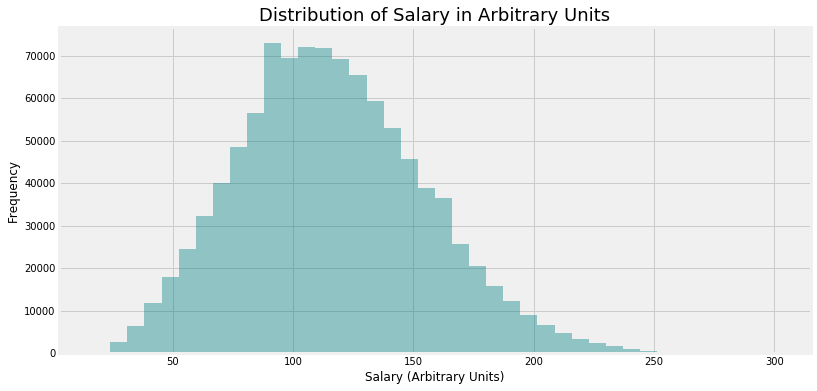

In [11]:
plt.figure(figsize=(12, 6))

sns.distplot(data_combined['salary'], kde=False, bins=40, color='teal')

plt.title('Distribution of Salary in Arbitrary Units', fontsize=18)
plt.xlabel('Salary (Arbitrary Units)')
plt.ylabel('Frequency')


**Investigate numerical variables 'yearsExperience' and 'milesFromMetropolis':**

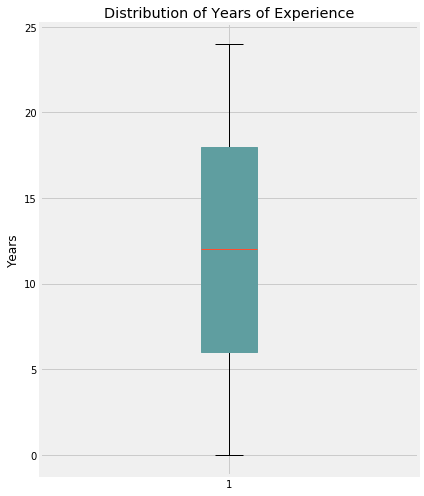

In [12]:
plt.figure(figsize=(6, 7))

plot_boxplot(data_combined,
             'yearsExperience',
             'cadetblue',
             'cadetblue',
             'Distribution of Years of Experience',
             'Years')


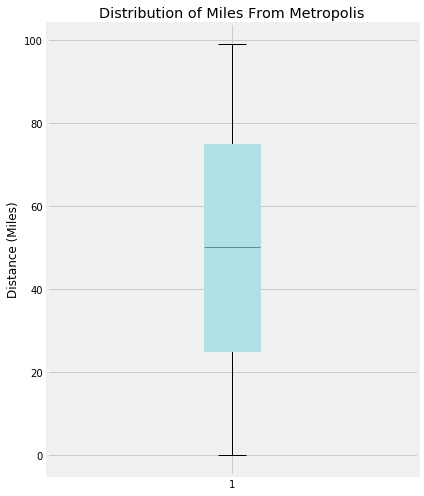

In [13]:
plt.figure(figsize=(6, 7))

plot_boxplot(data_combined,
             'milesFromMetropolis',
             'powderblue',
             'powderblue',
             'Distribution of Miles From Metropolis',
             'Distance (Miles)')

#### Investigate relationship between the above two interval variables and 'salary'

In [14]:
# take a small random sample of data for better visualisation

small_sample_data = data_combined.sample(n=3000, random_state=42)

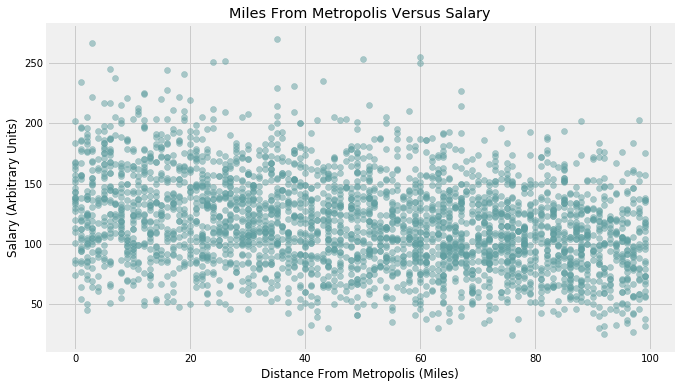

In [15]:
# Miles From Metropolis

plt.figure(figsize=(10, 6))

plot_scatter(small_sample_data, 'milesFromMetropolis', 'salary',
             0.5, 'cadetblue', 'Miles From Metropolis Versus Salary',
             'Distance From Metropolis (Miles)', 'Salary (Arbitrary Units)')

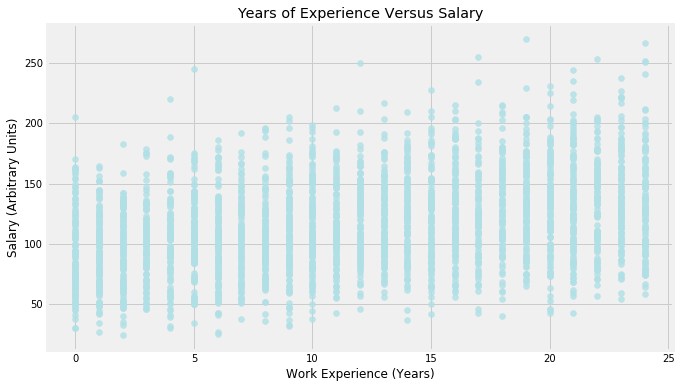

In [16]:
# Years Of Work Experience

plt.figure(figsize=(10, 6))

plot_scatter(small_sample_data, 'yearsExperience',
             'salary', 0.8, 'powderblue',
             'Years of Experience Versus Salary',
             'Work Experience (Years)', 'Salary (Arbitrary Units)')

**Interpretation:**

- 'Salary' is fairly normally distributed with a slight positive skew, which means the mean and the median are greater than the mode. The mean is being 'pulled' up by a few instances with very large values (above 250)


- The median of years of work experience required is 12. 50% of the postings require between approximately 6 and 17 years. There are cases where the job posting is aimed at those who are starting their careers, with 0 years of experience, and cases where postings require candidates who have been in the workforce for a long time, approaching 24 years


- On the other hand, there are a few jobs available in Metropolis (0 miles away from this city) and a few who require a long commute (nearly 100 miles). These are extreme points, as the majority of postings lie between 25 and 75 miles


- Distance from Metropolis and Salary have a very weak linear and negative relationship. Conversely, Years of Work experience and Salary have a very weak linear and positive relationship


- Since these are our two main interval features, we can question whether we need to scale them. From the y-axes of both boxplots, there is a noticeable difference in the magnitude of the data. We keep in mind this observation for now and will return to it if needed


----

#### Next I want to see the distributions of salary among different types industries. 

I will choose 3 diverse values for this variable just to get an idea of the data:

'AUTO', 'OIL' and 'EDUCATION'

In [17]:
# create dataframes

auto_salary_df = data_combined.loc[(data_combined['industry'] == 'AUTO')]

oil_salary_df = data_combined.loc[(data_combined['industry'] == 'OIL')]

education_salary_df = data_combined.loc[
                      (data_combined['industry'] == 'EDUCATION')]

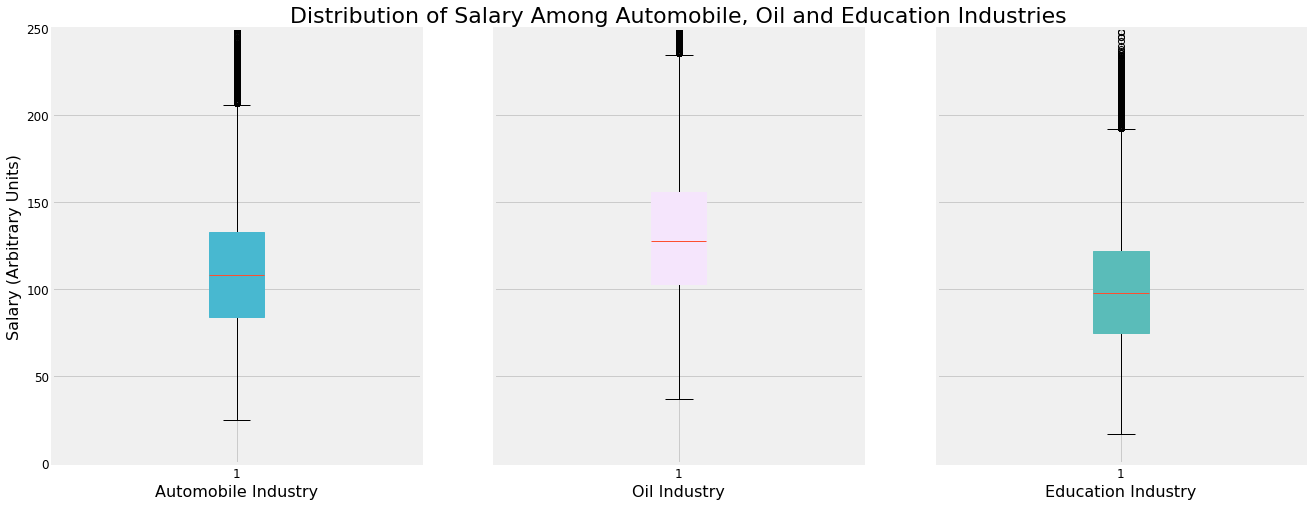

In [18]:
# create plots

fig, (ax1, ax2, ax3) = plt.subplots(
                       nrows=1, ncols=3, figsize=(20, 8),
                       sharey=True)

ax1.boxplot(auto_salary_df['salary'], patch_artist=True,
            boxprops=dict(facecolor='#48B8D0', color='#48B8D0'))

ax1.set_xlabel('Automobile Industry', fontsize=16)
ax1.set_ylabel('Salary (Arbitrary Units)', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(0, 250)


ax2.boxplot(oil_salary_df['salary'], patch_artist=True,
            boxprops=dict(facecolor='#F5E5FC', color='#F5E5FC'))

ax2.set_xlabel('Oil Industry', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=12)


ax3.boxplot(education_salary_df['salary'], patch_artist=True,
            boxprops=dict(facecolor='#5ABCB9', color='#5ABCB9'))

ax3.set_xlabel('Education Industry', fontsize=16)
ax3.tick_params(axis='both', which='major', labelsize=12)


ax2.set_title(
             'Distribution of Salary Among Automobile, Oil and Education Industries',
             fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=12)

**Interpretation**

There are noticeable but small differences among the 3 chosen industry in terms of salary distribution. 

- The highest-paying job postings in the Oil industry earn the most compared to their counterparts in the other two industries. The same can be said for the lowest-paying roles


- The middle 50% of job postings in Oil also pay more than the middle 50% in the Automobile and Education industries


- The salaries offered for jobs in the Automobile industry seem to lie in the middle of the other two industries


- Substantial numbers of outliers exist for all 3 industries

This visualisation suggests there may be a link between the type of industry one is in and the salary offered by the job. As a result, the type of industry may have some predictive power in computing new salaries.

---
#### Investigating mean salary per industry

In [19]:
industry_salary_df = data_combined.groupby(
                     'industry').mean().reset_index().sort_values('salary')

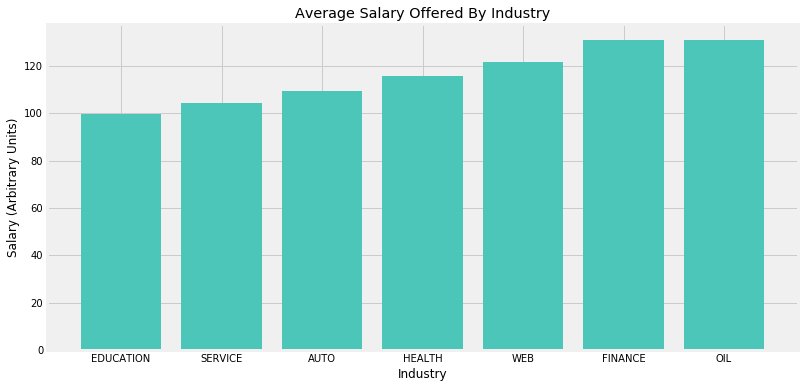

In [20]:
plt.figure(figsize=(12, 6))

plot_bar(industry_salary_df, 'industry', 'salary', '#4BC6B9',
         'Average Salary Offered By Industry', 'Industry',
         'Salary (Arbitrary Units)')

**Interpretation**

- Oil and Finance offer the highest paying jobs on average. Education and Service conversely offer the lowest paying jobs on average. These findings generally conform to what one would theorise about without having seen any data.



- The difference between the mean salary of an industry and the mean salary of the next highest-paying industry is fairly uniform for all industries. That is to say, average salary in the Service industry is slightly higher than in Education (let's call this difference 'A'). In turn, average salary in the Auto industry is slightly higher than in Service ('B'). A and B are of a similar magnitude and this is true for all industries

----

### Investigating how salary differs with job type/seniority

In [21]:
jobType_df = data_combined.loc[:, ['jobType', 'salary']].sort_values('salary')

In [22]:
# write function to sort salary by median

def boxplot_sorted(df, by, column, rot=0,
                   patch_artist=True,
                   showfliers=True):
    df2 = pd.DataFrame({col: vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    return df2[meds.index].boxplot(rot=rot, return_type="axes")

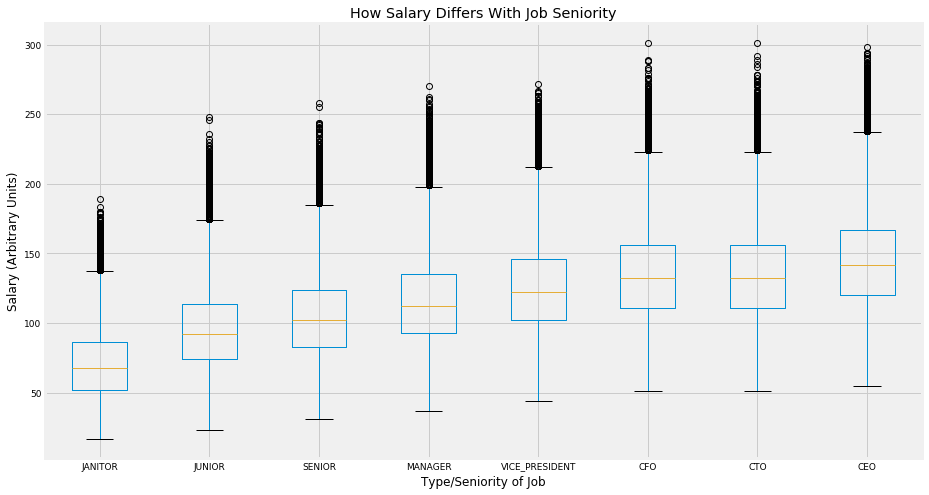

In [23]:
plt.figure(figsize=(14, 8))

boxplot_sorted(jobType_df, 'jobType', 'salary')

plt.title('How Salary Differs With Job Seniority')
plt.ylabel('Salary (Arbitrary Units)')
plt.xlabel('Type/Seniority of Job')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.show()

**Interpretation**

- The data suggests what one might expect; more senior roles usually pay higher salaries. The middle 50%, lowest paying and highest paying CEO, CFO and CTO jobs pay the most on average compared to other roles.


- Janitor and Junior jobs pay the least. This again conforms to common sense; these roles typically involve the least amount of leadership and decision-making, two highly important and sought after skills in the job market


- The distribution of salary is fairly well correlated with the seniority of the job overall. At the same time, however, we see that there is not much of a meaningful difference in average salary when we look at C-Suite jobs (CFO, CTO and CEO). The differences in mean salary between roles as split by seniority are most prominent in the more junior roles 

**Correlations between variables**

To find correlations between the categorical variables we have and salary, a good approach to take is simply to find the mean salary for each value of a categorical variable and compare these values with salary to find their correlation. Let us do that now.

In [24]:
df_corr = data_combined.copy(deep=True)

In [25]:
df_corr[['companyId',
         'jobType',
         'degree',
         'major',
         'industry']] = data_combined[['companyId',
                                       'jobType',
                                       'degree',
                                       'major',
                                       'industry']].astype('category')

df_columns_corr = ['companyId', 'jobType', 'degree', 'major', 'industry']

In [26]:
def lab_encoder(columns):
    for column in columns:
        df_corr[column] = df_corr.groupby(column).transform('mean')['salary']

In [27]:
lab_encoder(df_columns_corr)

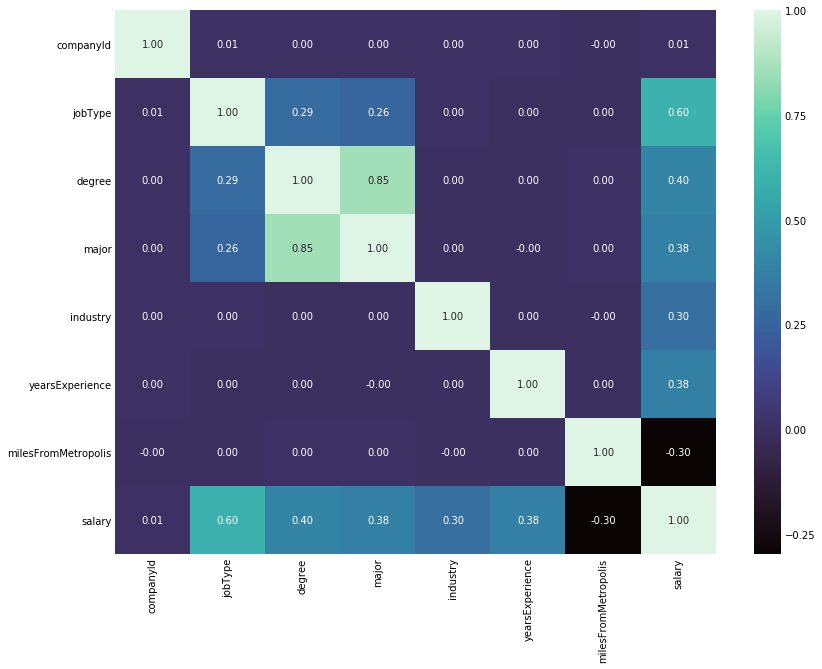

In [28]:
# create correlation matrix

plt.figure(figsize=(12, 10))

sns.heatmap(df_corr.corr(), annot=True, fmt='.2f', cmap='mako')

**Interpretation**

- **Interval variables**: As suggested by our initial scatterplots, 'milesFromMetropolis' has a weak, negative correlation with 'salary' while 'yearsExperience' has a weak, positive correlation with 'salary', with coefficients of -0.3 and 0.38 respectively


- **Categorical variables**: JobType has the strongest (positive) correlation with salary out of all features, at 0.6. It is followed by degree, major and industry with coefficients of 0.4, 0.38 and 0.3, respectively. It is interesting that out of the 4 categorical variables, the 2 that are ordinal have stronger correlations than the two that are nominal. This will be explained further when we arrive at encoding these these categorical features, which is a prerequisite to use them in an ML algorithm


- These statistics suggest that all of our features (with the exception of Company ID) have predictive power, some more so than others. 

###  Establishing a baseline

For a baseline model, I will use the average salary per industry as the prediction. 

I will then calculate RMSE to find a benchmark to improve upon.

In [29]:
data_combined['Baseline Prediction'] = data_combined.groupby(
                                       'industry')['salary'].transform('mean')

In [30]:
# separate features, output and baseline predictions from one another

X_train = data_combined[['jobId', 'companyId', 'jobType',
                         'degree', 'major', 'industry',
                         'yearsExperience', 'milesFromMetropolis']]

y_train = data_combined['salary']

y_predicted = data_combined['Baseline Prediction']

In [31]:
# calculate MSE

rmse = sqrt(mean_squared_error(y_train, y_predicted))

print('The baseline model RMSE is {}'.format(rmse))

The baseline model RMSE is 36.974625769373986


For referencial purposes, I will also calculate MSE:

In [32]:
mse = rmse**2
print('The baseline model MSE is {}'.format(mse))

The baseline model MSE is 1367.122950785255


### Hypothesising A Solution

The three models I have chosen to train are:

**Linear and Polynomial Regression**: Linear regression is a simple and effective model that serves as a good place to start. We saw from our EDA that the two interval variables we have a weak linear relationship with salary. 

Combined with the newly encoded categorical variables that are engineered in the following cells, which linear regression can handle easily, it is worthwhile to see how Linear Regression performs as a simple model, over which we can use more advanced models or ensemble methods if the need arises


**Linear SVR**: Support Vector Machines are powerful and versatile models. Although SVMs are primarily used for classification tasks, we use the SVM Regression version (scikit-learn's LinearSVR class) which is used for regression tasks. This is also powerful as it can handle both linear and nonlinear regression. 

However, we will not explore nonlinear regression with SVR. This is because the kernalised SVM model, which can be used for nonlinear regression, scales poorly with data size, unlike the LinearSVR class which scales linearly with data size 

**Gradient Boosting Regressor**: Finally, I would like to use an ensemble method, and a Gradient Boosting Regressor would be an appropriate choice. Ensemble methods can combined several weak learners into a strong learner. Gradient Boosting in particular trains individual learners sequentially, with each subsequent learner being fitted on the residuals of the prior learner. 

Morever, an ensemble method such as Gradient Boosting generally trades a bit more bias for less variance as well, which is useful in generalising a model to unseen data

----

In terms of new features, the first priority is to encode our categorical features 'major', 'degreeType', 'jobType' and 'industry'

Two of these features are ordinal and two are nominal. As a result, different encoding techniques will be required

Just as we created the mean salary per industry as a baseline prediction, it could be valuable to create a mean salary per job type feature

On the other hand, the data does not lend itself to any meaningful interaction variables, so these will not be explored

## Part 3 - Engineering Features & Developing Models

### Convert categorical features to numerical features: 'degree'

Let us first encode the 'degree' column type.

'Degree' can be considered a ordinal variable (the order of the data matters) more so than a nominal one (the order does not matter); clearly, a Doctoral degree is more advanced than a Master's degree, which itself is more advanced than a Bachelor's degree

As a result, it would seem the best way to convert this categorical feature into numbers is to manually encode them, where 0 may correspond to 'NONE' (no degree), 1 to 'HIGH_SCHOOl', 2 to 'BACHELORS' and so on.

We could use Label Encoding, but this option does not guarantee the order we want. For example, 'HIGH_SCHOOL' may be assigned to '3' (undesirable) and not '0' (desirable)

In [33]:
data_combined.degree.value_counts()

HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64

In [34]:
data_combined['Degree Category'] = data_combined['degree']

In [35]:
data_combined = data_combined.replace({'Degree Category':
                                       {'NONE': 0, 'HIGH_SCHOOL': 1,
                                        'BACHELORS': 2, 'MASTERS': 3,
                                        'DOCTORAL': 4}})

### Convert categorical features to numerical features: 'jobType'


Similar to 'degree', 'jobType' can also be considered an ordinal variable, not a nominal one, because a CEO role has the highest possible seniority, followed by a CFO role and so on until a janitor role\*


Therefore, we perform the same transformation here as we did above

\**There is some ambiguity regarding which of CFO or CTO is the more senior rank as this often depends on company context; I will simply consider CFO to be the more senior rank since this has historically been the case*

In [36]:
data_combined.jobType.value_counts()

SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64

In [37]:
data_combined['Job Type Category'] = data_combined['jobType']

data_combined = data_combined.replace({'Job Type Category':
                                       {'JANITOR': 0, 'JUNIOR': 1,
                                        'SENIOR': 2, 'MANAGER': 3,
                                        'VICE_PRESIDENT': 4, 'CTO': 5,
                                        'CFO': 6, 'CEO': 7}})

In [38]:
data_combined

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,Baseline Prediction,Degree Category,Job Type Category
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,115.735540,3,6
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,121.645362,1,7
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,115.735540,4,4
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,109.435222,4,3
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,130.747659,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88,115.735540,2,4
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160,130.747659,1,5
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64,99.448386,1,1
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149,115.735540,3,6


### Convert categorical features to numerical features: 'major'

Unlike 'degree' and 'jobType', 'major' cannot be considered to be an ordinal variable. 'Physics' cannot be said to be greater or lesser in some intuitive way than 'Engineering'. As a result, manual label encoding that maps options to different numbers (1, 2, 3...) is not the optimal approach here


Hence, it would be better to use dummy variables. One disadvantage of this, as referred to before, is that this will add many sparse columns to our dataframe. This may slow down our model training

In [39]:
major_dummy_data = pd.get_dummies(data_combined['major'])

# rename newly created dummies
for column in major_dummy_data.columns:
    major_dummy_data.rename(columns={column: 'major_' + str(column)}, inplace=True)

In [40]:
data_combined = pd.concat([data_combined, major_dummy_data], axis=1)

### Convert categorical features to numerical features: 'industry'

Similar to the 'major' variable, 'industry' is also nominal; we cannot intuitively order its values. Again, we will create dummy variables

In [41]:
industry_dummy_data = pd.get_dummies(data_combined['industry'])

for column in industry_dummy_data.columns:
    industry_dummy_data.rename(
                              columns={column: 'industry_' + str(column)},
                              inplace=True)


industry_dummy_data.head()

,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0


In [42]:
data_combined = pd.concat([data_combined, industry_dummy_data], axis=1)

### Create mean salary for each job type

In [43]:
data_combined['Mean Salary Per Job Type'] = data_combined.groupby(
                                                                 'jobType')['salary'].transform('mean')

### Checking for correlations between selected newly engineered features and 'salary'

We will investigate only the ordinal features and mean salary per job type. Including dummy variables in the correlation heatmap will lead to a congested visualisation

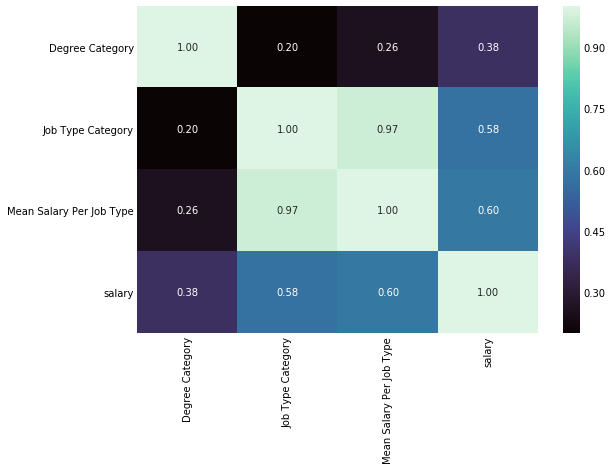

In [44]:
plt.figure(figsize=(8, 6))

new_features_data = data_combined[['Degree Category', 'Job Type Category',
                                   'Mean Salary Per Job Type', 'salary']]

sns.heatmap(new_features_data.corr(), annot=True, fmt='.2f', cmap='mako')

Thankfully, our newly created features seem to have decent predictive power, as suggested by the correlation coefficients.


These coefficients are 0.38, 0.58 and 0.6 for Degree Category, Job Type Category and Mean Salary Per Job Type, respectively

### Create and Test models 

In [45]:
# repeat step of separating features, output and 
# baseline predictions from one another to include
# newly created features

X_train = data_combined
X_train = X_train.drop(['salary', 'jobId', 'companyId',
                        'jobType', 'degree', 'major',
                        'industry'], axis=1)

y_train = data_combined['salary']

#### My metric will be MSE and my goal is <360

In [47]:
# initialise models

lr = linear_model.LinearRegression()
svm_reg = LinearSVR(epsilon=0.1)
gb_reg = GradientBoostingRegressor()
rf_reg = RandomForestRegressor()


# for linear svc

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)


# for GB regressor

sample_data = data_combined.sample(n=500000, random_state=42)

X_train_sample_500k = sample_data.drop(['salary', 'jobId', 'companyId',
                                        'jobType', 'degree', 'major',
                                        'industry'], axis=1)

y_train_sample_500k = sample_data['salary']

In [54]:
# loop through different regressors

regressors = [lr, svm_reg, gb_reg]

mse_df = pd.DataFrame(columns=['Regressor', '5-fold MSE Mean'])

for reg in regressors:

    name = reg.__class__.__name__

    if reg == svm_reg:
        mse_score = cross_val_score(reg, X_train_scaled, y_train,
                                    cv=5, scoring='neg_mean_squared_error')
        mse_mean = mse_score.mean()

    elif reg == gb_reg:

        mse_score = cross_val_score(reg, X_train_sample_500k,
                                    y_train_sample_500k, cv=5,
                                    scoring='neg_mean_squared_error')
        mse_mean = mse_score.mean()

    else:

        mse_score = cross_val_score(reg, X_train, y_train,
                                    cv=5, scoring='neg_mean_squared_error')
        mse_mean = mse_score.mean()

    log_entry = pd.DataFrame([[name, mse_mean]],
                             columns=['Regressor', '5-fold MSE Mean'])

    mse_df = mse_df.append(log_entry)

In [55]:
mse_df.sort_values('5-fold MSE Mean', ascending=False, inplace=True)
round(mse_df, 2)

,Regressor,5-fold MSE Mean
0,GradientBoostingRegressor,-366.45
0,LinearRegression,-386.64
0,LinearSVR,-387.86


The GradientBoostingRegressor is the best performer so far. I want to fit one more model, which is polynomial regression. It may be the case that adding more features gives us more predictive power

### Polynomial Regression with Degree = 2

In [57]:
# create polynomial features with degree = 2

pr = PolynomialFeatures(degree=2, include_bias=False)

x_polly = pr.fit_transform(X_train)

poly_reg_score = cross_val_score(lr, x_polly, y_train, cv=5,
                                 scoring='neg_mean_squared_error')

In [58]:
print(poly_reg_score.mean())

-354.1293058563211


Polynomial Regression with n = 2 gives us the best performing model so far, better than the Gradient Boosting Regressor

---

Now it is a good idea to perform a grid search and find the optimal hyperparameter values for our Gradient Boosting Regressor and LinearSVC models. I am not tuning my polynomial regression model even though it is the best model, because it does not have many hyperparameters to tune.

To perform a grid search, I will take another, smaller sample of data to speed this process up

In [57]:
sample_data = data_combined.sample(n=10000, random_state=42)

X_train_sample_10k = sample_data.drop(['salary', 'jobId', 'companyId',
                                       'jobType', 'degree', 'major',
                                       'industry'], axis=1)

y_train_sample_10k = sample_data['salary']

In [58]:
pipe = Pipeline([("regressor", LinearSVR(max_iter=100000))])


grid_param = [{'regressor': [(LinearSVR(max_iter = 100000))],
               'regressor__epsilon': [0.01, 0.05, 1],
               'regressor__C': [0.01, 0.1, 0.5, 0.9]},

              {'regressor': [GradientBoostingRegressor()],
               'regressor__learning_rate': [0.1, 0.5],
               'regressor__n_estimators': [100, 300],
               'regressor__max_features': [5, 10],
               'regressor__min_samples_split': [10, 50, 100],
               'regressor__max_depth': [4, 8]}]

grid_search = GridSearchCV(pipe, grid_param, cv=5,
                           scoring='neg_mean_squared_error')
best_model = grid_search.fit(X_train_sample_10k, y_train_sample_10k)

In [59]:
print(best_model.best_estimator_)
print('MSE of best model is {}%'.format(best_model.score(X_train, y_train)))

Pipeline(memory=None,
         steps=[('regressor',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=4,
                                           max_features=10, max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=100,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           presort='auto', random_state=None,
                                           subsample=1.0, tol=0.0001,
                                

Interestingly, grid search provides us with a GB Regressor model with an MSE of 369 units; this is worse than the default configuration of GB Regressor which gave us 366 units. One possibility behind this is that I am not passing the right ranges of parameters into grid search to be iterated through. 

Since GB Regressor trains models sequentially, it does not scale well with data. For that reason, I am not going to re-run grid search with differing combinations of parameters until I see an improvement in MSE beyond 366 units. Doing so will be computationally expensive and take a lot of time

### Selecting the best model 

The best model is polynomial regression with degree = 2. It achieved an MSE of 354, a 74.1% improvement over the baseline model MSE of 1367.12

## Part 4 - Deploy

### Automating our pipeline

In [4]:
# write script that trains model on entire training set, saves model to disk,
# and scores the "test" dataset

# load test feature data

test_data = pd.read_csv("data/test_features.csv")

# perform same feature engineering on test features as on train features

# encode ordinal variables
test_data['Degree Category'] = test_data['degree']  # degree variable

test_data = test_data.replace({'Degree Category':
                               {'NONE': 0, 'HIGH_SCHOOL': 1,
                                'BACHELORS': 2, 'MASTERS': 3,
                                'DOCTORAL': 4}}, inplace=True)

test_data['Job Type Category'] = test_data['jobType']  # job type variable

test_data = test_data.replace({'Job Type Category':
                               {'JANITOR': 0, 'JUNIOR': 1, 
                                'SENIOR': 2, 'MANAGER': 3,
                                'VICE_PRESIDENT': 4, 'CTO': 5,
                                'CFO': 6, 'CEO': 7}}, inplace=True)

# encode nominal variables
major_dummy_data = pd.get_dummies(test_data['major'])  # major variable

for column in major_dummy_data.columns:
    major_dummy_data.rename(
                           columns = {column: 'major_' + str(column)}, inplace=True)

test_data = pd.concat([test_data, major_dummy_data], axis=1)



industry_dummy_data = pd.get_dummies(test_data['industry'])  # industry variable

for column in industry_dummy_data.columns:
    industry_dummy_data.rename(
                              columns = {column: 'industry_' + str(column)}, inplace=True)

test_data = pd.concat([test_data, industry_dummy_data], axis=1)


# drop unnecessary features on test set

X_test = test_data.drop(['jobId', 'companyId',
                         'jobType', 'degree', 'major',
                         'industry'], axis=1)


# write function to train model on train data then make predictions on test data

def train_test_model(model, X_train, y_train, X_test, y_test):


    X_train = X_train.drop(['salary', 'jobId', 'companyId',
                            'jobType', 'degree', 'major',
                            'industry'], axis=1)


    # initialise tuned model
    model = GradientBoostingRegressor(n_estimators=160, learning_rate=0.1,
                                      max_depth=4, max_features=10,
                                      min_samples_split=1000)

    # fit model on X_train and y_train
    model.fit(X_train, y_train)

    # predict y_predicted using trained model
    y_predicted = model.predict(X_test)

    # test model and print mse
    mse = metrics.mean_squared_error(y_test, y_predicted)

    print('The MSE score on the test set is {}'.format(mse))

### Summary of Model Performance - MSE

In [38]:
# create dataframe

mse_performance_data = pd.DataFrame(columns=['Model', 'MSE'])
mse_performance_data['Model'] = pd.Series(['Linear Regression',
                                           'Polynomial Regression (n = 2)',
                                           'Linear SVR',
                                           'Decision Tree Regressor',
                                           'GB Regressor',
                                           'GB Regressor (tuned)'])

mse_performance_data['MSE'] = pd.Series([386.64, 354.13,
                                         387.89, 689.75,
                                         380.30, 358.43])

mse_performance_data.sort_values('MSE', ascending=False, inplace=True)

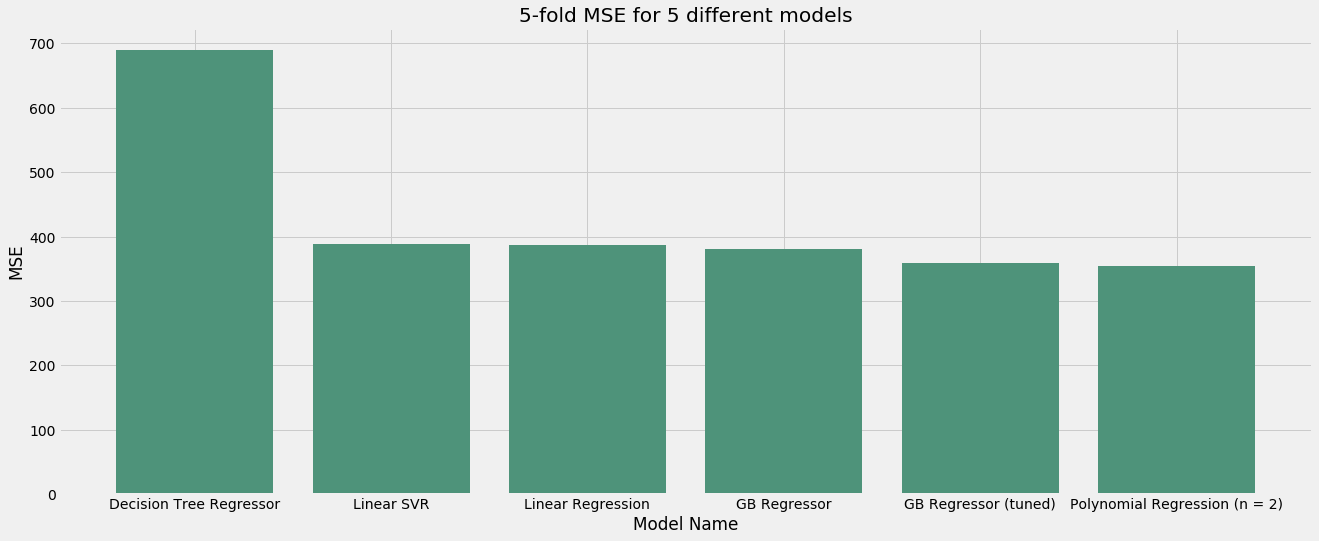

In [139]:
# plot

plt.figure(figsize=(20, 8))

plot_bar(mse_performance_data, 'Model', 'MSE', '#4E937A',
         '5-fold MSE for 5 different models', 'Model Name',
         'MSE')

### Save model and predictions 

In [ ]:
# save predictions

predicted_salary = y_predicted

# save to CSV file

predicted_salary.to_csv('/Users/User Name/Desktop/Predicted Salaries.csv')

# Save the trained model

gb_reg_tuned = GradientBoostingRegressor(n_estimators=160,
                                         learning_rate=0.1,
                                         max_depth=4,
                                         max_features=10,
                                         min_samples_split=1000)

gb_reg_tuned.fit(X_train, y_train)

gb_reg_tuned_saved = pickle.dumps(gb_reg_tuned)